<a href="https://colab.research.google.com/github/ItayShalit/Intro-to-Deep-Learning/blob/main/Intro_to_DL_Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
from torch.nn.utils import skip_init
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
import numpy as np
from sys import maxsize
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

## Part 1


### Data Loading

In [32]:
TRAIN_SIZE = 5000
TEST_SIZE = 1000

gen = torch.Generator()
gen.manual_seed(2022)

trainset = torchvision.datasets.CIFAR10(root = './data', train = True, download = True, 
                                        transform = transforms.ToTensor())

sample_train_idx = torch.randint(len(trainset), size=(TRAIN_SIZE,), generator = gen)



testset = torchvision.datasets.CIFAR10(root = './data', train = False,
                                       download = True, transform = transforms.ToTensor())
sample_test_idx = torch.randint(len(testset), size=(TEST_SIZE,), generator = gen)


Files already downloaded and verified
Files already downloaded and verified


### Training an SVM Classifier 

In [3]:
MAX_INTENSITY = 255

train_x = trainset.data/MAX_INTENSITY
train_y = trainset.targets

test_x = testset.data/MAX_INTENSITY
test_y = testset.targets

train_x = train_x.reshape(train_x.shape[0], -1)
train_x = train_x[sample_train_idx,:]
train_y = np.array(train_y)[sample_train_idx]

test_x = test_x.reshape(test_x.shape[0], -1)
test_x = test_x[sample_test_idx,:]
test_y = np.array(test_y)[sample_test_idx]

#### Hyperparameter Tuning

In [6]:
param_grid1 = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.001],'kernel': ['rbf']}
param_grid2 = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.001],'kernel': ['linear']}

grid1 = GridSearchCV(SVC(),param_grid1, refit=True, verbose=2, n_jobs = -1)
grid2 = GridSearchCV(SVC(),param_grid2, refit=True, verbose=2, n_jobs = -1)

grid1.fit(train_x, train_y)
print("best parameters for grid1: ", grid1.best_params_)

grid2.fit(train_x, train_y)
print("best parameters for grid2: ", grid2.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
best parameters for grid1:  {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
Fitting 5 folds for each of 12 candidates, totalling 60 fits
best parameters for grid2:  {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}


#### Training the Models

In [4]:
#best parameters for grid1:  {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
#best parameters for grid2:  {'C': 0.1, 'gamma': 1, 'kernel': 'linear'}

# params1 = grid1.best_params_
# params2 = grid2.best_params_

params1 = {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
params2 = {'C': 0.1, 'gamma': 1, 'kernel': 'linear'}

rbf_model = SVC(C = params1["C"], kernel = "rbf", gamma = params1["gamma"])
linear_model = SVC(C = params2["C"], kernel = "linear", gamma = params2["gamma"])

rbf_model.fit(train_x, train_y)
linear_model.fit(train_x, train_y)

test_pred_rbf = rbf_model.predict(test_x)
test_pred_linear = linear_model.predict(test_x)

print(f"""accuracy score for linear model is: {accuracy_score(test_y, test_pred_linear)} \n 
        accuracy score for rbf model is: {accuracy_score(test_y, test_pred_rbf)}""")


# accuracy score for linear model is: 0.349 
 
# accuracy score for rbf model is: 0.423

accuracy score for linear model is: 0.349 
 
        accuracy score for rbf model is: 0.423


## Part 2
### Baseline

In [41]:
# class FFNeuralNetwork(nn.Module):
#     def __init__(self):
#         super(FFNeuralNetwork, self).__init__()
#         self.flatten = nn.Flatten()
#         input_layer = skip_init(nn.Linear, 3072, 256) #To save computations, Parameter initialization is currently skipped, 
#                                                       #and will be done before training using a custom distribution.
#         hidden_layer = skip_init(nn.Linear, 256, 10)
#         self.linear_relu_stack = nn.Sequential(
#             input_layer,
#             nn.ReLU(),
#             hidden_layer,
#         )

#     def forward(self, x):
#         x = self.flatten(x)
#         logits = self.linear_relu_stack(x)
#         return logits

class FFNeuralNetwork(nn.Module):
    def __init__(self):
        super(FFNeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        input_layer = nn.Linear(3072, 256) #To save computations, Parameter initialization is currently skipped, 
                                                      #and will be done before training using a custom distribution.
        hidden_layer = nn.Linear(256, 10)
        self.linear_relu_stack = nn.Sequential(
            input_layer,
            nn.ReLU(),
            hidden_layer,
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


# class NeuralNetwork(nn.Module):
#     def __init__(self):
#         super(NeuralNetwork, self).__init__()
#         self.flatten = nn.Flatten()
#         self.linear_relu_stack = nn.Sequential(
#             nn.Linear(28*28, 512),
#             nn.ReLU(),
#             nn.Linear(512, 512),
#             nn.ReLU(),
#             nn.Linear(512, 10),
#         )

#     def forward(self, x):
#         x = self.flatten(x)
#         logits = self.linear_relu_stack(x)
#         return logits

In [42]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

model = FFNeuralNetwork()

if torch.cuda.device_count() > 1:
  print("Using", torch.cuda.device_count(), "GPUs")
  model = nn.DataParallel(model)

model.to(device)
print(model)

Using cuda device
FFNeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=3072, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=10, bias=True)
  )
)


In [63]:
def train_loop(dataloader, model, loss_fn, optimizer, device, print_progress = False):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if print_progress&(batch % 100 == 0):
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn, device, return_results = False):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    # print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    if return_results:
      return test_loss, correct

def train_and_plot_results(trainloader, testloader, model, loss_fn, optimizer, epochs, device, figure = None, plot_results = True, label_addition = ''):
  train_accuracy_vals, train_loss_vals, test_accuracy_vals, test_loss_vals = [], [], [], []
  for t in range(epochs):
      train_loop(trainloader, model, loss_fn, optimizer, device)
      train_loss, train_accuracy = test_loop(trainloader, model, loss_fn, device, True)
      test_loss, test_accuracy = test_loop(testloader, model, loss_fn, device, True)
      train_loss_vals.append(train_loss)
      train_accuracy_vals.append(train_accuracy)
      test_loss_vals.append(test_loss)
      test_accuracy_vals.append(test_accuracy)
  if figure == None:
    figure = plt.figure(figsize=(18, 6))
    ax1 = figure.add_subplot(1,2,1)
    ax2 = figure.add_subplot(1,2,2) 
  ax1 = figure.get_axes()[0]
  ax2 = figure.get_axes()[1]
  ax1.plot([i for i in range(epochs)], train_accuracy_vals, label = 'train_accuracy ' + label_addition)
  ax1.plot([i for i in range(epochs)], test_accuracy_vals, label = 'test_accuracy ' + label_addition)
  ax2.plot([i for i in range(epochs)], train_loss_vals, label = 'train_loss ' + label_addition)
  ax2.plot([i for i in range(epochs)], test_loss_vals, label = 'test_loss ' + label_addition)
    
  ax1.legend()
  ax2.legend()
  if plot_results:
    figure.show()

#### Hyperparameter Tuning

In [47]:

learning_rate_vals = [1e-1, 1e-2, 1e-3]
init_std_vals = [1e-5, 1e-3, 1e-1]
momentum_param_vals = [0.9, 0.95, 0.99] 

best_loss = maxsize
best_configuration = {'learning_rate':None, 'init_std': None, 'momentum_param': None}

loss_fn = nn.CrossEntropyLoss()
batch_size = 64
epochs = 50

# trainset.data.to("cuda")
# testset.data.to("cuda")

trainsubset = torch.utils.data.Subset(trainset, sample_train_idx)
testsubset = torch.utils.data.Subset(testset, sample_test_idx)
#Should sample the same samples as those I used for training and testing SVM.
trainloader = torch.utils.data.DataLoader(trainsubset, batch_size = batch_size,
                                          num_workers=2, shuffle = True)
testloader = torch.utils.data.DataLoader(testsubset, batch_size = batch_size,
                                          num_workers=2, shuffle = True)

# trainloader.pin_memory = True
# testloader.pin_memory = True


for learning_rate in learning_rate_vals:
  for init_std in init_std_vals:
    for momentum_param in momentum_param_vals:
      torch.nn.init.normal_(model.linear_relu_stack[0].weight, mean=0.0, std=init_std)
      torch.nn.init.normal_(model.linear_relu_stack[2].weight, mean=0.0, std=init_std)
      optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum_param)
      for t in range(epochs):
        # print(f"Epoch {t+1}\n-------------------------------")
        train_loop(trainloader, model, loss_fn, optimizer, device)
        # test_loop(test_dataloader, model, loss_fn)
      loss, accuracy = test_loop(testloader, model, loss_fn,  device, True)
      print("learning rate: ", learning_rate, "init_std: ", init_std , "momentum_param: ", momentum_param, "loss: ", loss)
      if loss<best_loss:
        best_loss = loss
        best_configuration["learning rate"] = learning_rate
        best_configuration["momentum_param"] = momentum_param
        best_configuration["init_std"] = init_std

# learning rate:  0.1 init_std:  1e-05 momentum_param:  0.9 loss:  2.307101294398308
# learning rate:  0.1 init_std:  1e-05 momentum_param:  0.95 loss:  2.312568709254265
# learning rate:  0.1 init_std:  1e-05 momentum_param:  0.99 loss:  2.347815290093422
# learning rate:  0.1 init_std:  0.001 momentum_param:  0.9 loss:  2.279910624027252
# learning rate:  0.1 init_std:  0.001 momentum_param:  0.95 loss:  2.30678454041481
# learning rate:  0.1 init_std:  0.001 momentum_param:  0.99 loss:  2.320346012711525
# learning rate:  0.1 init_std:  0.1 momentum_param:  0.9 loss:  2.3357246220111847
# learning rate:  0.1 init_std:  0.1 momentum_param:  0.95 loss:  2.3064474165439606
# learning rate:  0.1 init_std:  0.1 momentum_param:  0.99 loss:  2.3136157542467117
# learning rate:  0.01 init_std:  1e-05 momentum_param:  0.9 loss:  2.054948665201664
# learning rate:  0.01 init_std:  1e-05 momentum_param:  0.95 loss:  2.090452328324318
# learning rate:  0.01 init_std:  1e-05 momentum_param:  0.99 loss:  2.3036657124757767
# learning rate:  0.01 init_std:  0.001 momentum_param:  0.9 loss:  2.0752763226628304
# learning rate:  0.01 init_std:  0.001 momentum_param:  0.95 loss:  2.3025175034999847
# learning rate:  0.01 init_std:  0.001 momentum_param:  0.99 loss:  2.307538539171219
# learning rate:  0.01 init_std:  0.1 momentum_param:  0.9 loss:  1.7154605239629745
# learning rate:  0.01 init_std:  0.1 momentum_param:  0.95 loss:  1.8431001007556915
# learning rate:  0.01 init_std:  0.1 momentum_param:  0.99 loss:  2.211473226547241
# learning rate:  0.001 init_std:  1e-05 momentum_param:  0.9 loss:  2.303907573223114
# learning rate:  0.001 init_std:  1e-05 momentum_param:  0.95 loss:  2.3025937974452972
# learning rate:  0.001 init_std:  1e-05 momentum_param:  0.99 loss:  2.302464634180069
# learning rate:  0.001 init_std:  0.001 momentum_param:  0.9 loss:  2.3025242537260056
# learning rate:  0.001 init_std:  0.001 momentum_param:  0.95 loss:  2.3028661012649536
# learning rate:  0.001 init_std:  0.001 momentum_param:  0.99 loss:  2.30242195725441
# learning rate:  0.001 init_std:  0.1 momentum_param:  0.9 loss:  1.8239069506525993
# learning rate:  0.001 init_std:  0.1 momentum_param:  0.95 loss:  1.7650010138750076
# learning rate:  0.001 init_std:  0.1 momentum_param:  0.99 loss:  1.8518539294600487


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


learning rate:  0.1 init_std:  1e-05 momentum_param:  0.9 loss:  2.307101294398308
learning rate:  0.1 init_std:  1e-05 momentum_param:  0.95 loss:  2.312568709254265
learning rate:  0.1 init_std:  1e-05 momentum_param:  0.99 loss:  2.347815290093422
learning rate:  0.1 init_std:  0.001 momentum_param:  0.9 loss:  2.279910624027252
learning rate:  0.1 init_std:  0.001 momentum_param:  0.95 loss:  2.30678454041481
learning rate:  0.1 init_std:  0.001 momentum_param:  0.99 loss:  2.320346012711525
learning rate:  0.1 init_std:  0.1 momentum_param:  0.9 loss:  2.3357246220111847
learning rate:  0.1 init_std:  0.1 momentum_param:  0.95 loss:  2.3064474165439606
learning rate:  0.1 init_std:  0.1 momentum_param:  0.99 loss:  2.3136157542467117
learning rate:  0.01 init_std:  1e-05 momentum_param:  0.9 loss:  2.054948665201664
learning rate:  0.01 init_std:  1e-05 momentum_param:  0.95 loss:  2.090452328324318
learning rate:  0.01 init_std:  1e-05 momentum_param:  0.99 loss:  2.3036657124757

#### Plotting training procces with best configuration

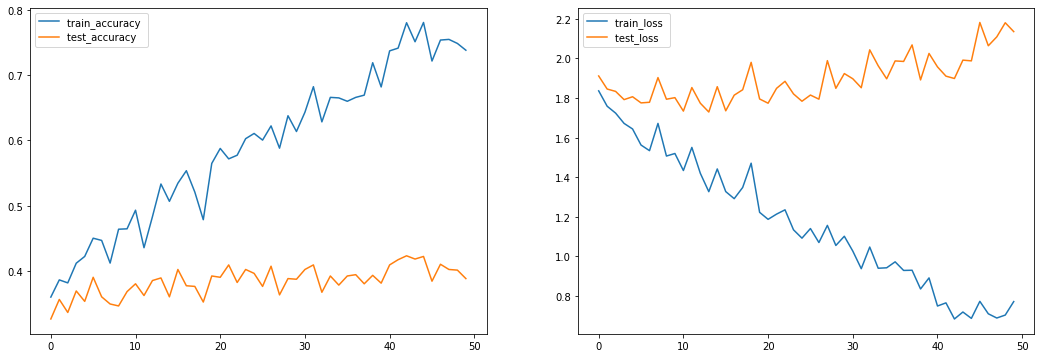

In [65]:
best_configuration = {'init_std': 0.1, 'learning rate': 0.01, 'momentum_param': 0.9}

torch.nn.init.normal_(model.linear_relu_stack[0].weight, mean=0.0, std=best_configuration['init_std'])
torch.nn.init.normal_(model.linear_relu_stack[2].weight, mean=0.0, std=best_configuration['init_std'])
optimizer = torch.optim.SGD(model.parameters(), lr=best_configuration["learning rate"], momentum=best_configuration["momentum_param"])
train_and_plot_results(trainloader, testloader, model, loss_fn, optimizer, epochs, device)

#### Optimization

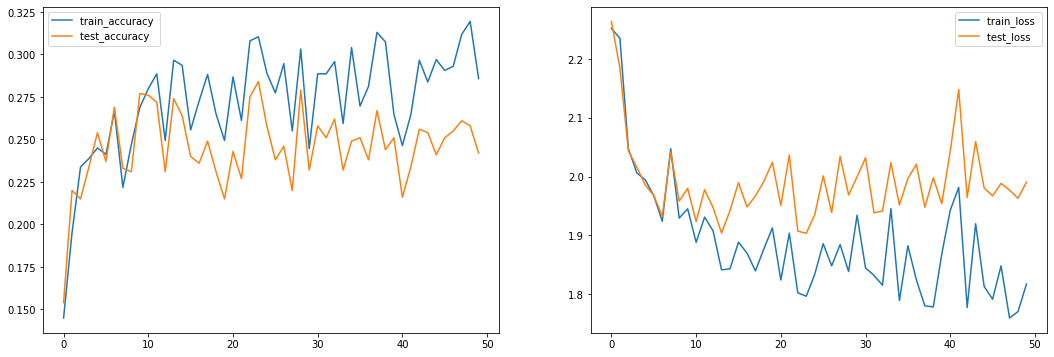

In [66]:
torch.nn.init.normal_(model.linear_relu_stack[0].weight, mean=0.0, std=best_configuration['init_std'])
torch.nn.init.normal_(model.linear_relu_stack[2].weight, mean=0.0, std=best_configuration['init_std'])
optimizer = torch.optim.Adam(model.parameters(), lr=best_configuration["learning rate"], betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
train_and_plot_results(trainloader, testloader, model, loss_fn, optimizer, epochs, device)

#### Initialization

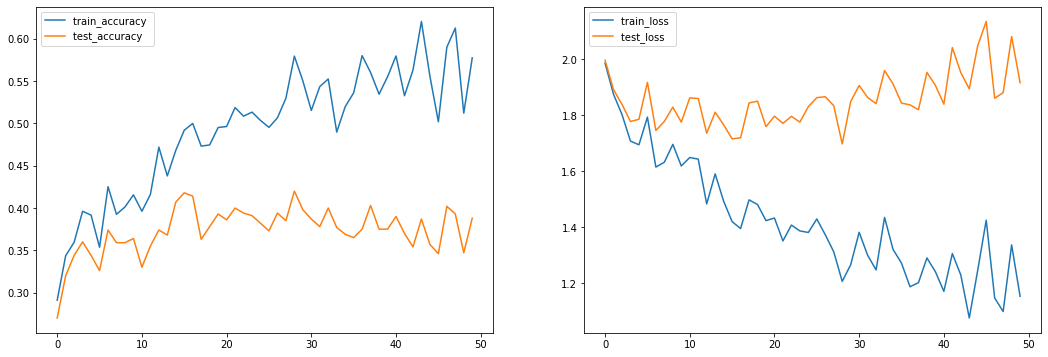

In [69]:
torch.nn.init.xavier_normal_(model.linear_relu_stack[0].weight)
torch.nn.init.xavier_normal_(model.linear_relu_stack[2].weight)
optimizer = torch.optim.SGD(model.parameters(), lr=best_configuration["learning rate"], momentum=best_configuration["momentum_param"])
train_and_plot_results(trainloader, testloader, model, loss_fn, optimizer, epochs, device)

#### Weight Decay

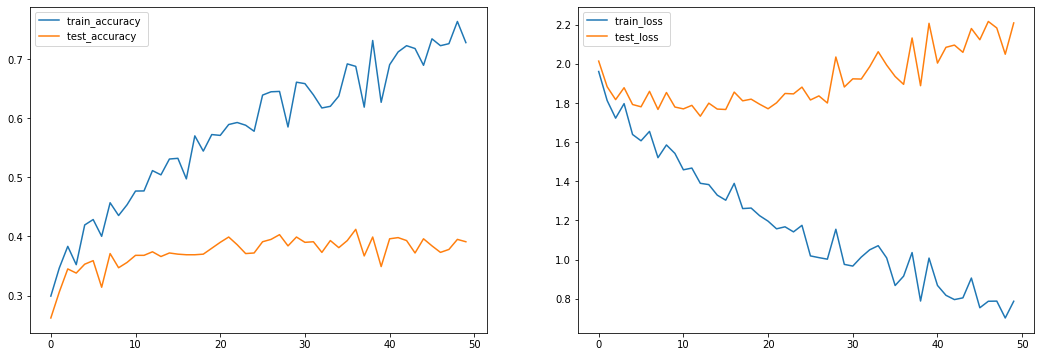

In [70]:
torch.nn.init.normal_(model.linear_relu_stack[0].weight, mean=0.0, std=best_configuration['init_std'])
torch.nn.init.normal_(model.linear_relu_stack[2].weight, mean=0.0, std=best_configuration['init_std'])
optimizer = torch.optim.SGD(model.parameters(), lr=best_configuration["learning rate"], momentum=best_configuration["momentum_param"], weight_decay=1e-4)
train_and_plot_results(trainloader, testloader, model, loss_fn, optimizer, epochs, device)

#### Dropout

In [71]:
class FFNeuralNetworkDropout(nn.Module):
    def __init__(self):
        super(FFNeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        input_layer = skip_init(nn.Linear, 3072, 256) #To save computations, Parameter initialization is currently skipped, 
                                                      #and will be done before training using a custom distribution.
        hidden_layer = skip_init(nn.Linear, 256, 10)
        self.dropout = nn.dropout(0.25)
        self.linear_relu_stack = nn.Sequential(
            input_layer,
            nn.dropout(0.25),
            nn.ReLU(),
            hidden_layer,
            nn.dropout(0.25)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [72]:
model = FFNeuralNetworkDropout().to(device)
torch.nn.init.normal_(model.linear_relu_stack[0].weight, mean=0.0, std=best_configuration.init_std)
torch.nn.init.normal_(model.linear_relu_stack[2].weight, mean=0.0, std=best_configuration.init_std)
optimizer = torch.optim.SGD(model.parameters(), lr=best_configuration["learning rate"], momentum=best_configuration["momentum_param"], weight_decay=1e-4)
train_and_plot_results(trainloader, testloader, model, loss_fn, optimizer, epochs, device)

TypeError: ignored

#### PCA Whitening

In [ ]:
class FFNeuralNetwork(nn.Module):
    def __init__(self):
        super(FFNeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        input_layer = skip_init(nn.Linear, 20, 256) #To save computations, Parameter initialization is currently skipped, 
                                                      #and will be done before training using a custom distribution.
        hidden_layer = skip_init(nn.Linear, 256, 10)
        self.linear_relu_stack = nn.Sequential(
            input_layer,
            nn.ReLU(),
            hidden_layer,
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

pca = PCA(n_components=20, whiten=True, random_state=10)
train_x_pca = pca.fit_transform(train_x)
test_x_pca = pca.fit_transform(test_x)
tensor_trainx = torch.Tensor(train_x_pca)
tensor_trainy = torch.Tensor(train_y)
tensor_testx = torch.Tensor(test_x_pca)
tensor_testy = torch.Tensor(test_y)

trainset_pca = torch.utils.data.TensorDataset(tensor_trainx,tensor_trainy)
testset_pca = torch.utils.data.TensorDataset(tensor_testx,tensor_testy)

trainsubset_pca = torch.utils.data.Subset(trainset_pca, sample_train_idx)
testsubset_pca = torch.utils.data.Subset(testset_pca, sample_test_idx)
#Should sample the same samples as those I used for training and testing SVM.
trainloader_pca = torch.utils.data.DataLoader(trainsubset_pca, batch_size = batch_size,
                                          num_workers=2, shuffle = True)
testloader_pca = torch.utils.data.DataLoader(testsubset_pca, batch_size = batch_size,
                                          num_workers=2, shuffle = True)

torch.nn.init.normal_(model.linear_relu_stack[0].weight, mean=0.0, std=best_configuration.init_std)
torch.nn.init.normal_(model.linear_relu_stack[2].weight, mean=0.0, std=best_configuration.init_std)
optimizer = torch.optim.SGD(model.parameters(), lr=best_configuration["learning rate"], momentum=best_configuration["momentum_param"])
train_and_plot_results(trainloader_pca, testloader_pca, model, loss_fn, optimizer, epochs, device)

#### Network Width

In [ ]:
def NNClassGeneratorByWidth(width):
  class FFNeuralNetwork(nn.Module):
      def __init__(self):
          super(FFNeuralNetwork, self).__init__()
          self.flatten = nn.Flatten()
          input_layer = skip_init(nn.Linear, 3072, width) #To save computations, Parameter initialization is currently skipped, 
                                                        #and will be done before training using a custom distribution.
          hidden_layer = skip_init(nn.Linear, width, 10)
          self.linear_relu_stack = nn.Sequential(
              input_layer,
              nn.ReLU(),
              hidden_layer,
          )

      def forward(self, x):
          x = self.flatten(x)
          logits = self.linear_relu_stack(x)
          return logits
  return FFNeuralNetwork

figure = plt.figure(figsize=(1,2))
ax1 = figure.add_subplot(1,2,1)
ax2 = figure.add_subplot(1,2,2) 
width_vals = [6, 10, 12]

for width in width_vals:
  NNClass = NNClassGeneratorByWidth(2**width)
  model = NNClass().to(device)
  torch.nn.init.normal_(model.linear_relu_stack[0].weight, mean=0.0, std=best_configuration.init_std)
  torch.nn.init.normal_(model.linear_relu_stack[2].weight, mean=0.0, std=best_configuration.init_std)
  optimizer = torch.optim.SGD(model.parameters(), lr=best_configuration["learning rate"], momentum=best_configuration["momentum_param"])
  train_and_plot_results(trainloader, testloader, model, loss_fn, optimizer, epochs, device, figure = figure, plot_results = False, label_addition = f'width 2^{width}')

figure.show()
  

#### Network Depth

In [ ]:
def NNClassGeneratorByDepth(depth):
  class FFNeuralNetwork(nn.Module):
      def __init__(self):
          super(FFNeuralNetwork, self).__init__()
          self.flatten = nn.Flatten()
          sequence = [skip_init(nn.Linear, 3072, 64)]
          for i in range(depth-1):
            sequence.append(nn.ReLU())
            sequence.append(skip_init(nn.Linear, 64, 64))
          sequence.append(nn.ReLU())
          sequence.append(skip_init(nn.Linear, 64, 10))
          self.linear_relu_stack = nn.Sequential(sequence)

      def forward(self, x):
          x = self.flatten(x)
          logits = self.linear_relu_stack(x)
          return logits
  return FFNeuralNetwork




In [ ]:
epochs = 30 #Here we decrease the number of epochs, because of the increase in network depth

figure = plt.figure(figsize=(1,2))
ax1 = figure.add_subplot(1,2,1)
ax2 = figure.add_subplot(1,2,2) 
depth_vals = [6, 10, 12]

for depth in depth_vals:
  NNClass = NNClassGeneratorByDepth(depth)
  model = NNClass().to(device)
  torch.nn.init.normal_(model.linear_relu_stack[0].weight, mean=0.0, std=best_configuration.init_std)
  torch.nn.init.normal_(model.linear_relu_stack[2].weight, mean=0.0, std=best_configuration.init_std)
  optimizer = torch.optim.SGD(model.parameters(), lr=best_configuration["learning rate"], momentum=best_configuration["momentum_param"])
  train_and_plot_results(trainloader, testloader, model, loss_fn, optimizer, epochs, device, figure = figure, plot_results = False, label_addition = f'depth {depth}')

figure.show()
